### HVS Data Processing Pipeline

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, Galactic

# set up paths
print("Imported libraries successfully...")
script_dir = os.getcwd()
root = os.path.abspath(os.path.join(script_dir, os.pardir))
input_path = os.path.join(root, 'data', 'raw', 'source_data.csv')
output_path_gaia = os.path.join(root, 'data', 'processed', 'gaia_data.csv')
output_path_cartesian = os.path.join(root, 'data', 'processed', 'monte_carlo_cartesian.csv')
output_path_pos_cov = os.path.join(root, 'data', 'processed', 'positional_covariance.csv')
output_path_vel_cov = os.path.join(root, 'data', 'processed', 'velocity_covariance.csv')
print("Input path: " + str(input_path))


Imported libraries successfully...
Input path: /mnt/c/Users/aqin/Desktop/HVS/data/raw/source_data.csv


In [27]:
# Load CSV into Pandas dataframe
df = pd.read_csv(input_path, delimiter=',')
pd.set_option('display.width', 180)
print(df)
print(df.columns)

    HVS            source_id          vhelio          pmra         pmdec          dhelio   pMW  pLMC  log_z_MW
0     1   577294697514301440   831.10 ± 5.70  -0.60 ± 0.60  -0.47 ± 0.39  102.24 ± 14.60  0.72  0.12    -0.490
1     4   699811079173836928   600.90 ± 6.20  -0.20 ± 0.26  -0.60 ± 0.19    63.80 ± 9.70  0.92  0.01    -2.600
2     5  1069326945513133952   545.50 ± 4.30   0.00 ± 0.08  -0.99 ± 0.11    44.20 ± 5.09  0.00  0.00       NaN
3     6  3867267443277880320   609.40 ± 6.80   0.12 ± 0.30   0.12 ± 0.23    55.36 ± 6.88  0.00  0.46     7.000
4     7  3799146650623432704   526.90 ± 3.00  -0.09 ± 0.18   0.02 ± 0.13    52.17 ± 6.25  0.00  0.49    27.000
5     8   633599760258827776   499.30 ± 2.90  -0.88 ± 0.16  -0.28 ± 0.14    53.19 ± 9.80  0.00  0.00   -53.000
6     9  3830584196322129920   616.80 ± 5.10   0.26 ± 0.43  -0.81 ± 0.65   74.10 ± 11.60  0.44  0.77    -0.130
7    10  3926757653770374272   467.90 ± 5.60  -1.09 ± 0.45  -0.99 ± 0.21    51.76 ± 5.72  0.57  0.80    -0.380
8

In [28]:
# Clean columns with +- format, drop unneeded columns (pMW, pLMC, log_z_MW)
# vhelio, pmra, pmdec, dhelio are replaced by val and error columns

cols_to_clean = ['vhelio', 'pmra', 'pmdec', 'dhelio']
for col in cols_to_clean:
    split_data = df[col].str.split(' ± ', expand=True)
    df[f"{col}_val"] = pd.to_numeric(split_data[0])
    df[f"{col}_err"] = pd.to_numeric(split_data[1])

cols_to_drop = ['vhelio', 'pmra', 'pmdec', 'dhelio', 'pMW', 'pLMC', 'log_z_MW']
for col in cols_to_drop:
    df = df.drop(col, axis=1)

print(df)

    HVS            source_id  vhelio_val  vhelio_err  pmra_val  pmra_err  pmdec_val  pmdec_err  dhelio_val  dhelio_err
0     1   577294697514301440       831.1         5.7     -0.60      0.60      -0.47       0.39      102.24       14.60
1     4   699811079173836928       600.9         6.2     -0.20      0.26      -0.60       0.19       63.80        9.70
2     5  1069326945513133952       545.5         4.3      0.00      0.08      -0.99       0.11       44.20        5.09
3     6  3867267443277880320       609.4         6.8      0.12      0.30       0.12       0.23       55.36        6.88
4     7  3799146650623432704       526.9         3.0     -0.09      0.18       0.02       0.13       52.17        6.25
5     8   633599760258827776       499.3         2.9     -0.88      0.16      -0.28       0.14       53.19        9.80
6     9  3830584196322129920       616.8         5.1      0.26      0.43      -0.81       0.65       74.10       11.60
7    10  3926757653770374272       467.9        

In [29]:
# Query DR3 database for RA and Dec values and merge with original dataframe
source_ids = df['source_id'].tolist()

# ADQL query to get values from Gaia DR3
query = f"""
SELECT
    source_id, ra, dec, ra_error, dec_error, parallax, parallax_error
FROM
    gaiadr3.gaia_source
WHERE
    source_id IN {tuple(source_ids)}
"""
print("Launching job to get results from Gaia database...")
job = Gaia.launch_job_async(query)
gaia_results = job.get_results()

print("Results found. Merging with original database...")
gaia_df = gaia_results.to_pandas()
# print(gaia_df)
# print(df)
df = pd.merge(df, gaia_df, on='source_id')
final_column_order = [
    'HVS',
    'source_id',
    'ra',
    'ra_error',
    'dec',
    'dec_error',
    'vhelio_val',
    'vhelio_err',
    'pmra_val',
    'pmra_err',
    'pmdec_val',
    'pmdec_err',
    'dhelio_val',
    'dhelio_err',
    'parallax',
    'parallax_error'
]
df = df[final_column_order]

print("Dataframe merged. Printing final dataframe...")
print(df)


Launching job to get results from Gaia database...
INFO: Query finished. [astroquery.utils.tap.core]
Results found. Merging with original database...
Dataframe merged. Printing final dataframe...
    HVS            source_id          ra  ra_error        dec  dec_error  vhelio_val  vhelio_err  pmra_val  pmra_err  pmdec_val  pmdec_err  dhelio_val  dhelio_err  parallax  \
0     1   577294697514301440  136.937465  0.428983   2.751909   0.303029       831.1         5.7     -0.60      0.60      -0.47       0.39      102.24       14.60  0.190676   
1     4   699811079173836928  138.254179  0.205027  30.855519   0.140122       600.9         6.2     -0.20      0.26      -0.60       0.19       63.80        9.70 -0.087921   
2     5  1069326945513133952  139.497811  0.065225  67.377323   0.094973       545.5         4.3      0.00      0.08      -0.99       0.11       44.20        5.09 -0.149264   
3     6  3867267443277880320  166.489378  0.259884   9.577638   0.192968       609.4         6.8    

In [30]:
# Save final dataframe to a CSV.

df.to_csv(output_path_gaia, index=False)
print(f"Data saved to '{output_path_gaia}'")

Data saved to '/mnt/c/Users/aqin/Desktop/HVS/data/processed/gaia_data.csv'


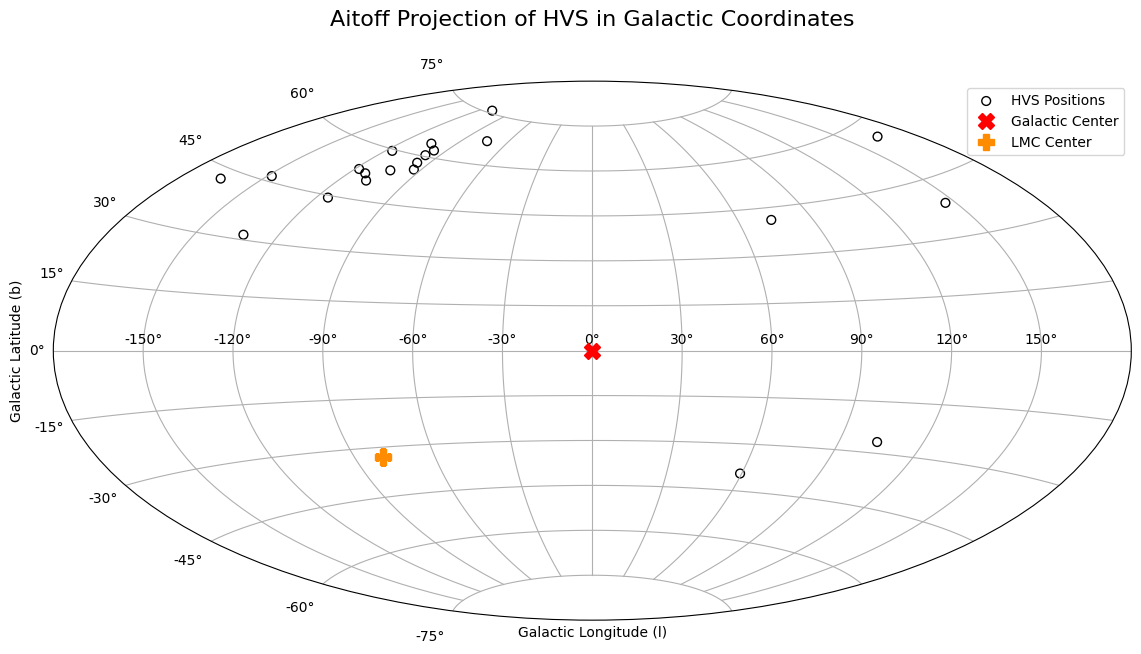

In [31]:
# aitoff projection using original RA, Dec values
df = pd.read_csv(output_path_gaia)

ra_deg = df['ra'].values * u.degree
dec_deg = df['dec'].values * u.degree

icrs_coords = SkyCoord(frame='icrs', ra=ra_deg, dec=dec_deg)
galactic_coords = icrs_coords.transform_to(Galactic)

l_rad = galactic_coords.l.wrap_at(180*u.degree).radian
b_rad = galactic_coords.b.radian

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

ax.scatter(l_rad, b_rad, s=40, facecolors='none', edgecolors='black', label='HVS Positions')
ax.plot(0, 0, 'X', color='red', markersize=12, label='Galactic Center')
lmc_l_rad = np.deg2rad(280.47 - 360)
lmc_b_rad = np.deg2rad(-32.91)
ax.plot(lmc_l_rad, lmc_b_rad, 'P', color='darkorange', markersize=12, label='LMC Center')

ax.set_title('Aitoff Projection of HVS in Galactic Coordinates', fontsize=16, pad=40)
ax.set_xlabel('Galactic Longitude (l)')
ax.set_ylabel('Galactic Latitude (b)')
ax.legend()
ax.grid(True, linestyle='-')

plt.show()



#### Convert to Cartesian (Galactocentric) frame
The galactic frame data 'gaia_data.csv' has now been fully processed. Move onto converting into galactocentric cartesian frame for future integration work.

In [ ]:
# convert to cartesian coordinate system via monte carlo
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from tqdm import tqdm

def convert_to_cartesian_w_errors(curr_data, num_samples=10000):
    """
    Monte Carlo error propogation for coordinate transformations into cartesian frame via Gaussian random sampling.
    """
    
    # convert errors to degrees
    ra_err_deg = curr_data['ra_error'] / 3.6e6
    dec_err_deg = curr_data['dec_error'] / 3.6e6

    # random sampling of components
    ra_samples = np.random.normal(curr_data['ra'], ra_err_deg, num_samples) * u.deg
    dec_samples = np.random.normal(curr_data['dec'], dec_err_deg, num_samples) * u.deg
    distance_samples = np.random.normal(curr_data['dhelio_val'], curr_data['dhelio_err'], num_samples) * u.kpc
    pmra_samples = np.random.normal(curr_data['pmra_val'], curr_data['pmra_err'], num_samples) * u.mas / u.yr
    pmdec_samples = np.random.normal(curr_data['pmdec_val'], curr_data['pmdec_err'], num_samples) * u.mas / u.yr
    radial_vel_samples = np.random.normal(curr_data['vhelio_val'], curr_data['vhelio_err'], num_samples) * u.km / u.s

    # create galactic frame skycoord object, convert to cartesian/galactocentric and return
    coords_galactic = SkyCoord(
        ra=ra_samples,
        dec=dec_samples,
        distance=distance_samples,
        pm_ra_cosdec=pmra_samples,
        pm_dec=pmdec_samples,
        radial_velocity=radial_vel_samples,
        frame='icrs'
    )

    coords_galcen = coords_galactic.transform_to(Galactocentric)

    pos_samples = np.array([
        coords_galcen.x.to_value(u.kpc),
        coords_galcen.y.to_value(u.kpc),
        coords_galcen.z.to_value(u.kpc)
    ])
    vel_samples = np.array([
        coords_galcen.v_x.to_value(u.km/u.s),
        coords_galcen.v_y.to_value(u.km/u.s),
        coords_galcen.v_z.to_value(u.km/u.s)
    ])
    
    mean_values = np.mean(np.vstack([pos_samples, vel_samples]), axis=1)
    std_devs = np.std(np.vstack([pos_samples, vel_samples]), axis=1)
    pos_covariance_matrix = np.cov(pos_samples)
    vel_covariance_matrix = np.cov(vel_samples)

    return mean_values, std_devs, pos_covariance_matrix, vel_covariance_matrix

# processing
# all lists of dictionaries for each star: main_results is mean values and std_error, pos_cov and vel_cov
# store positional and velocity covariance matrices respectively.

main_results = []
pos_cov_results = []
vel_cov_results = []

for index, star in tqdm(df.iterrows(), total=df.shape[0]):
    means, stds, pos_cov, vel_cov = convert_to_cartesian_w_errors(star)

    # main results 
    main_results.append({
        'HVS': star['HVS'], 'source_id': star['source_id'],
        'x': means[0], 'x_err': stds[0],
        'y': means[1], 'y_err': stds[1],
        'z': means[2], 'z_err': stds[2],
        'u': means[3], 'u_err': stds[3],
        'v': means[4], 'v_err': stds[4],
        'w': means[5], 'w_err': stds[5],
    })

    # store flattened covariance matrices
    pos_cov_results.append({
        'HVS': star['HVS'], 'source_id': star['source_id'],
        'cov_xx': pos_cov[0, 0], 'cov_xy': pos_cov[0, 1], 'cov_xz': pos_cov[0, 2],
        'cov_yy': pos_cov[1, 1], 'cov_yz': pos_cov[1, 2], 'cov_zz': pos_cov[2, 2]
    })
    
    vel_cov_results.append({
        'HVS': star['HVS'], 'source_id': star['source_id'],
        'cov_uu': vel_cov[0, 0], 'cov_uv': vel_cov[0, 1], 'cov_uw': vel_cov[0, 2],
        'cov_vv': vel_cov[1, 1], 'cov_vw': vel_cov[1, 2], 'cov_ww': vel_cov[2, 2]
    })

print("Stars processed.")

# save cartesian data with std_erors
df_main = pd.DataFrame(main_results)
df_main['HVS'] = df_main['HVS'].astype(int)
df_main['source_id'] = df_main['source_id'].astype('int64')
df_main.to_csv(output_path_cartesian, index=False, float_format='%.6f')
print(f"-> Main Cartesian data saved to '{output_path_cartesian}'")

# save positional covariance data
df_pos_cov = pd.DataFrame(pos_cov_results)
df_pos_cov['HVS'] = df_pos_cov['HVS'].astype(int)
df_pos_cov['source_id'] = df_pos_cov['source_id'].astype('int64')
df_pos_cov.to_csv(output_path_pos_cov, index=False, float_format='%.6f')
print(f"-> Positional covariance data saved to '{output_path_pos_cov}'")

# save velocity covariance data
df_vel_cov = pd.DataFrame(vel_cov_results)
df_vel_cov['HVS'] = df_vel_cov['HVS'].astype(int)
df_vel_cov['source_id'] = df_vel_cov['source_id'].astype('int64')
df_vel_cov.to_csv(output_path_vel_cov, index=False, float_format='%.6f')
print(f"-> Velocity covariance data saved to '{output_path_vel_cov}'")

print("\nDone.")

100%|██████████| 21/21 [00:00<00:00, 64.12it/s]

Stars processed.
-> Main Cartesian data saved to '/mnt/c/Users/aqin/Desktop/HVS/data/processed/monte_carlo_cartesian.csv'
-> Positional covariance data saved to '/mnt/c/Users/aqin/Desktop/HVS/data/processed/positional_covariance.csv'
-> Velocity covariance data saved to '/mnt/c/Users/aqin/Desktop/HVS/data/processed/velocity_covariance.csv'

Done.
